<a href="https://colab.research.google.com/github/fxnnxc/class-MachineLearning/blob/master/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification using neural networks

In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"/content/drive/My Drive/Colab Notebooks/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

num_features = 10000

# I didn't use this vectorization....
#vectorizer = CountVectorizer(max_features=num_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
#X = vectorizer.fit_transform(documents).toarray()
#tfidfconverter = TfidfTransformer()
#X = tfidfconverter.fit_transform(X).toarray()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Count words 
word_dict = {}

number = 0 
for d in documents:
  sent = d.split(' ')
  for w in sent:
      if w in word_dict:
        word_dict[w][1] +=1
      else:
        word_dict[w] = [number, 1]
        number+=1
# Number of Sentences S

S = len(documents)
low  = 0.005*S
high = 1.0*S

# Make smaller dictionary
word_dict2 = {}
number = 0
for w in word_dict:
  if low < word_dict[w][1] < high:
    word_dict2[w] = word_dict[w]
    word_dict2[w][0] = number
    number+=1

print(len(word_dict))
print(len(word_dict2))


40125
8260


In [12]:
# Make X data

import numpy as np
from sklearn.preprocessing import MinMaxScaler

positive =[] #긍정 레이블에 많이 포함된 단어 목록. 
negative =[] #부정 레이블에 많이 포함된 단어 목록.

X = np.zeros((len(documents), len(word_dict2)))
# Make X
for i, d in enumerate(documents):
  sent = d.split(' ')
  for w in sent:
      try:
        index  = word_dict2[w][0]
        X[i, index] +=1   
      except:
        pass

# OLS를 이용해서 전체 데이터에서 Positive, Negative를 찾는다. 
A = np.concatenate((X, np.ones((X.shape[0],1))), axis=1) # OLS
m = np.linalg.lstsq(A, y, rcond=None)

for i in range(len(m[0])-2):
  if m[0][i] > 0.03:
    positive.append(list(word_dict2.keys())[i])
  if m[0][i] < -0.03:
    negative.append(list(word_dict2.keys())[i])

# give more weights for X data 
for i, d in enumerate(documents):
  sent = d.split(' ')
  for w in sent:
      try:
        index  = word_dict2[w][0]
        if w in positive or w in negative:
          X[i, index] += 3
      except:
        pass

# Normalize
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
print(f"X:{X.shape}")
print(f"y:{y.shape}")



X:(2000, 8260)
y:(2000,)


In [0]:
# Install CuPy
#!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.1.0" CUPY_VERSION="==5.1.0" sh -
#!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
#!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80
#!pip install cupy
import cupy as cp

In [0]:
def one_hot(y):
  oneHotY = np.zeros((2, y.shape[0]))
  for i in range(y.shape[0]):
    index = int(y[i])
    oneHotY[index][i] = 1
  return oneHotY

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

y_train_index = y_train
y_test_index = y_test

y_train = one_hot(y_train)
y_test  = one_hot(y_test)

X_train = cp.asarray(X_train).T
X_test  = cp.asarray(X_test).T
y_train = cp.asarray(y_train)
y_test  = cp.asarray(y_test)
y_train_index = cp.asarray(y_train_index)
y_test_index  = cp.asarray(y_test_index)

In [0]:
# Utilities [ LOSS, ACCURACY ]
def loss_acc(clf, X, y, y_index):
  H = clf.forward(X)
  v = cp.sum(-cp.multiply(y, cp.log(H)) - cp.multiply(1-y, cp.log(1-H))) + clf.lamb * cp.mean(cp.multiply(clf.outlay,clf.outlay))/2
  
  w = cp.argmax(H, axis=0)
  w = cp.sum(cp.equal(w, y_index))
  return (v, w/H.shape[1]*100)

def sigmoid(x):  
  return 1/(1+cp.exp(-x))

In [0]:
# Classfier Class

class classifier():
    def __init__(self):
        # Shapes
        self.input_size  = X.shape[1]
        self.layer1_size = num_features//2
        self.layer2_size = num_features//4
        self.output_size = 2

        # Weights
        self.layer1 = cp.random.normal(0, 0.2, (self.layer1_size, self.input_size))   
        self.layer2 = cp.random.normal(0, 0.3, (self.layer2_size, self.layer1_size))  
        self.outlay = cp.random.normal(0, 0.5, (self.output_size, self.layer2_size)) 

        # Bias
        self.bias1 = cp.zeros((self.layer1_size, 1))
        self.bias2 = cp.zeros((self.layer2_size, 1))
        self.bias_ = cp.zeros((self.output_size, 1))

        # stores
        self.loss_train = []
        self.loss_test  = []
        self.acc_train  = []
        self.acc_test   = []

        # learing rate
        self.lr =  0.01
        self.lamb = 3e-2

        
    def forward(self, x):  # To predict right, worng answer and to calculate loss and accuracy
        # Layer 1
        output = self.layer1.dot(x) + self.bias1
        output = sigmoid(output)

        # Layer 2 
        output = self.layer2.dot(output) + self.bias2
        output = sigmoid(output)  

        # Output layer
        output = self.outlay.dot(output) + self.bias_
        output = sigmoid(output)

        return output

    def predict(self, X):
        H = self.forward(X)
        w = cp.argmax(H, axis=0)
        return w

    def train(self, x, y):
        # Forward -----------------------------------------------------------------
        # Layer 1
        input1 = x

        output = cp.dot(self.layer1, x) + self.bias1
        linval1 = output
        output = sigmoid(output)
        sigval1 = output

        # Layer 2    
        input2 = output
        output = cp.dot(self.layer2, output) + self.bias2
        linval2 = output
        output = sigmoid(output)
        sigval2 = output

        # Layer 3  

        # Output layer
        input_ = output
        output = cp.dot(self.outlay, output) + self.bias_
        output = sigmoid(output)

        # Backward ----------------------------------------------------------------
        temp_ = output-y                                                       # 역전파값
        dw = cp.dot(temp_, input_.T)/x.shape[1]
        db = cp.sum(temp_, axis=1, keepdims=True)/x.shape[1]

        self.outlay -= self.lr*dw
        self.outlay -= self.lr*self.lamb*self.outlay
        self.bias_  -= self.lr*db

        # layer2
        temp2 = cp.dot(dw.T, temp_)*cp.multiply(sigval2 ,(1-sigval2))           # 역전파값  
        db = cp.sum(temp2, axis=1, keepdims=True)/x.shape[1]                # bias
        dw = np.dot(temp2, input2.T)/x.shape[1]                            # weight

        self.layer2 -= self.lr*dw
        self.layer2 -= self.lr*self.lamb*self.layer2
        self.bias2  -= self.lr*db

        # layer1
        temp1 = cp.dot(dw.T,temp2) * cp.multiply(sigval1 ,(1-sigval1))         # 역전파  
        db = cp.sum(temp1, axis=1, keepdims=True)/x.shape[1]                  # bias
        dw = np.dot(temp1, input1.T)/x.shape[1]                            # weight

        self.layer1 -= self.lr*dw
        self.layer1 -= self.lr*self.lamb*self.layer1
        self.bias1  -= self.lr*db

        return 


clf = classifier()

In [0]:
# Training

COUNT = 7000
for k in range(0, COUNT+1):

  clf.train(X_train, y_train)
  a,b = loss_acc(clf, X_train, y_train, y_train_index)
  c,d = loss_acc(clf, X_test, y_test, y_test_index)
  clf.loss_train.append(a)
  clf.loss_test.append(c)
  clf.acc_train.append(b)
  clf.acc_test.append(d)


# Result



## Plot the loss curve

The training loss and testing loss at every iteration of gradient descent

Text(0.5, 1.0, 'Loss Curve')

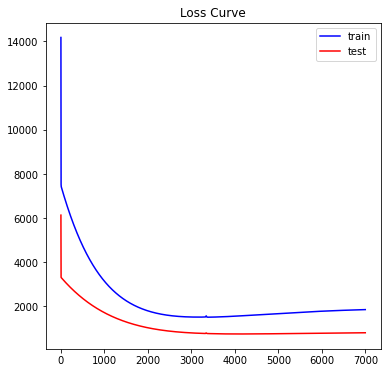

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(clf.loss_train, color='b')
plt.plot(clf.loss_test,  color='r')
plt.legend(['train', 'test'])
plt.title('Loss Curve')

## Plot the accuracy curve

The training accuracy (%) and testing accuracy (%) at every iteration of gradient descent

Text(0.5, 1.0, 'Accuracy Curve')

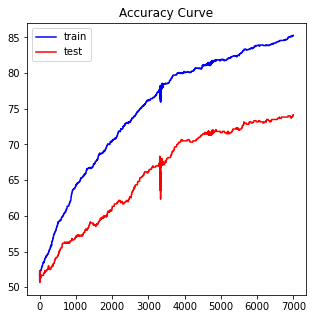

In [122]:
plt.figure(figsize=(5,5))
plt.plot(clf.acc_train, color='b')
plt.plot(clf.acc_test , color='r')
plt.legend(['train', 'test'])
plt.title('Accuracy Curve')

## Plot the quantitative results

In [124]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion Matrix of training data")
print(confusion_matrix(y_train_index.tolist(),       clf.predict(X_train).tolist()))
print(classification_report(y_train_index.tolist(),  clf.predict(X_train).tolist()))
print("Accuracy of Training Data", accuracy_score(y_train_index.tolist(),         clf.predict(X_train).tolist()))
print("\n\n")

print("Confusion Matrix of testing data")
print(confusion_matrix(y_test_index.tolist(),       clf.predict(X_test).tolist()))
print(classification_report(y_test_index.tolist(),  clf.predict(X_test).tolist()))
print("Accuracy of Testing Data", accuracy_score(y_test_index.tolist(),         clf.predict(X_test).tolist()))


Confusion Matrix of training data
[[539 159]
 [ 74 628]]
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       698
           1       0.80      0.89      0.84       702

    accuracy                           0.83      1400
   macro avg       0.84      0.83      0.83      1400
weighted avg       0.84      0.83      0.83      1400

Accuracy of Training Data 0.8335714285714285



Confusion Matrix of testing data
[[197 105]
 [ 46 252]]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       302
           1       0.71      0.85      0.77       298

    accuracy                           0.75       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.76      0.75      0.75       600

Accuracy of Testing Data 0.7483333333333333
